<a href="https://colab.research.google.com/github/jfraska/smart-cowshed/blob/master/smart_cowshed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import system libs
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from PIL import Image
import random
from shutil import copyfile

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Get dataset
os.environ['KAGGLE_USERNAME'] = "alifianzulfaani"
os.environ['KAGGLE_KEY'] = "4b8aa99d8f0cfab2b85c684ad6864489"
!kaggle datasets download -d alifianzulfaani/new-cowshed-dataset

# Extract dataset
from zipfile import ZipFile
file_name = "/content/new-cowshed-dataset.zip"
zp = ZipFile(file_name, 'r')
zp.extractall(path='/content/')
print('done')

 88% 76.0M/86.7M [00:01<00:00, 90.3MB/s]
100% 86.7M/86.7M [00:01<00:00, 76.0MB/s]
done


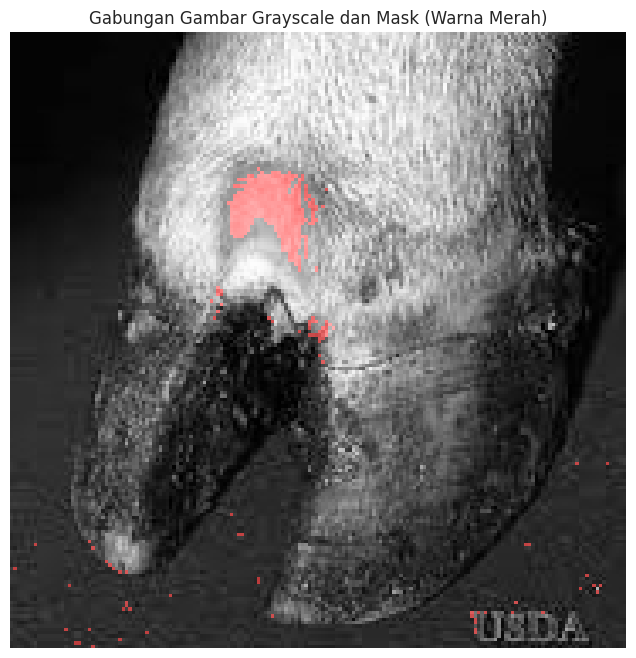

In [3]:
# Load gambar
image = cv2.imread('/content/dataset-cowshed/pmk/kuku/kuku-sakit (41).jpg')

# Konversi gambar ke ruang warna HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Tentukan rentang warna merah untuk ekstraksi
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# Buat mask untuk daerah dengan warna merah
mask = cv2.inRange(hsv, lower_red, upper_red)

# Konversi gambar asli ke grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Konversi mask dengan satu saluran menjadi tiga saluran (merah)
red_mask = cv2.merge([np.zeros_like(mask), np.zeros_like(mask), mask])

# Gabungkan gambar grayscale dengan mask (dengan transparansi)
combined = cv2.addWeighted(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR), 1, red_mask, 0.5, 0)

# Tampilkan gambar gabungan
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title("Gabungan Gambar Grayscale dan Mask (Warna Merah)")
plt.axis('off')
plt.show()

In [4]:
# Directories
dir_list = ['/content/dataset-cowshed/pmk/', '/content/dataset-cowshed/sehat/']
cat = ['kuku', 'mulut']

base_dir = '/content/dataset'
train_dir = '/content/dataset/train/'
val_dir = '/content/dataset/validation/'
test_dir = '/content/dataset/test/'

train_aug = '/content/augmented/train/'
val_aug = '/content/augmented/validation/'
test_aug = '/content/augmented/test/'
classes = [
'pmk_kuku', 'pmk_mulut', 'sehat_kuku', 'sehat_mulut']

In [5]:
# Create directories above
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(val_dir)
os.mkdir(test_dir)

for i in classes:
  os.mkdir(os.path.join(train_dir,i))
for j in classes:
  os.mkdir(os.path.join(val_dir,j))
for k in classes:
  os.mkdir(os.path.join(test_dir,k))

In [6]:
# Split dataset

def split_data(source, training, validation, test, split_size):
    files = []
    for filename in os.listdir(source):
        file = os.path.join(source, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * split_size)  # data training 70%
    val_length = int(len(files) * ((1 - split_size) * (2/3)))  # data validasi 20%

    shuffled_set = random.sample(files, len(files))

    training_set = shuffled_set[0:training_length]
    val_set = shuffled_set[training_length:training_length + val_length]
    test_set = shuffled_set[training_length + val_length:]

    for filename in training_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(training, filename)
        copyfile(this_file, destination)

    for filename in val_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(validation, filename)
        copyfile(this_file, destination)

    for filename in test_set:
        this_file = os.path.join(source, filename)
        destination = os.path.join(test, filename)
        copyfile(this_file, destination)

split_size = 0.7
x = 0
y = 0

for i in classes:
    if x == len(cat):
        x = 0
        y += 1
    split_data(dir_list[y] + cat[x] + '/', train_dir + i + '/', val_dir + i + '/', test_dir + i + '/', split_size)
    x += 1

def count_data(input_dir, title):
    print('Data ' + title)
    for j in classes:
        print(' {} : '.format(j) + str(len(os.listdir(input_dir + '/' + j + '/'))))
    print()

# Gunakan fungsi count_data untuk menghitung jumlah data di direktori pelatihan, validasi, dan pengujian
count_data(train_dir, "Training")
count_data(val_dir, "Validation")
count_data(test_dir, "Testing")

Data Training
 pmk_kuku : 35
 pmk_mulut : 28
 sehat_kuku : 31
 sehat_mulut : 34

Data Validation
 pmk_kuku : 10
 pmk_mulut : 8
 sehat_kuku : 9
 sehat_mulut : 9

Data Testing
 pmk_kuku : 6
 pmk_mulut : 5
 sehat_kuku : 5
 sehat_mulut : 6



In [7]:
# Image augmentation
IMG_WIDTH = 150
IMG_HEIGHT = 150
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
)

def aug_img(input_dir, output_dir, nums):
    itr = 0
    for each_data in classes:
        dataset = []

        image_directory = os.path.join(input_dir, each_data)
        dataset = []

        my_images = os.listdir(image_directory)
        for i, image_name in enumerate(my_images):
            if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image = io.imread(os.path.join(image_directory, image_name))
                image = Image.fromarray(image, 'RGB')
                image = image.resize((IMG_WIDTH, IMG_HEIGHT))
                dataset.append(np.array(image))

        x = np.array(dataset)
        aug_dir = os.path.join(output_dir, each_data)
        os.makedirs(aug_dir, exist_ok=True)

        i = 1
        for batch in datagen.flow(x, batch_size=32,
                                  save_to_dir=aug_dir,
                                  save_prefix='aug',
                                  save_format='png'):
            i += 1
            if i > nums[itr]:
                break

        itr += 1
        print(f'Augmented images in {each_data}: {len(os.listdir(aug_dir))}')

num_train = [10, 7, 7, 10]
num_val = [9, 10, 10, 10]
num_test = [1, 1, 1, 1]

aug_img(train_dir, train_aug, num_train)
aug_img(val_dir, val_aug, num_val)
aug_img(test_dir, test_aug, num_test)

Augmented images in pmk_kuku: 175
Augmented images in pmk_mulut: 196
Augmented images in sehat_kuku: 217
Augmented images in sehat_mulut: 170
Augmented images in pmk_kuku: 90
Augmented images in pmk_mulut: 80
Augmented images in sehat_kuku: 90
Augmented images in sehat_mulut: 90
Augmented images in pmk_kuku: 6
Augmented images in pmk_mulut: 5
Augmented images in sehat_kuku: 5
Augmented images in sehat_mulut: 6


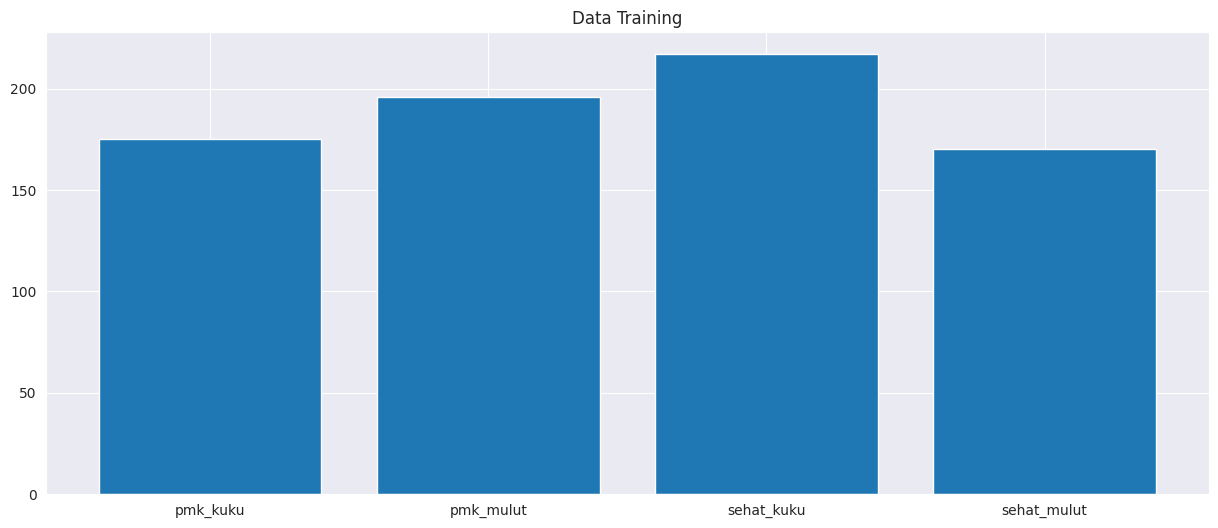

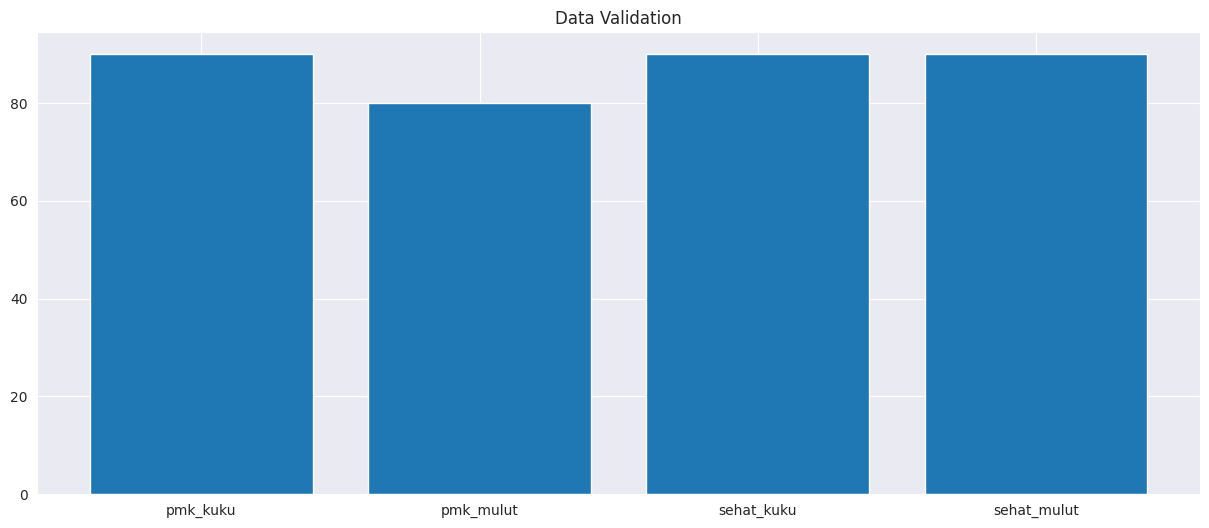

In [8]:
def bar_vis(input_dir, title, classes):
    nimgs = {}
    for i in classes:
        nimages = len(os.listdir(os.path.join(input_dir, i)))
        nimgs[i] = nimages

    plt.figure(figsize=(15, 6))
    plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
    plt.xticks(range(len(nimgs)), list(nimgs.keys()))
    plt.title('Data ' + title)
    plt.show()

bar_vis(train_aug, 'Training', classes)
bar_vis(val_aug, 'Validation', classes)

def count_data(input_dir, title, classes):
    print('Data ' + title)
    for j in classes:
        print(' {} : '.format(j) + str(len(os.listdir(os.path.join(input_dir, j)))))
    print()

In [9]:
# Processing Data
BATCH_SIZE = 32

def myFunc(image):
    # Konversi gambar ke ruang warna HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Tentukan rentang warna merah untuk ekstraksi
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])

    # Buat mask untuk daerah dengan warna merah
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # Konversi gambar asli ke grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Konversi mask dengan satu saluran menjadi tiga saluran (merah)
    red_mask = cv2.merge([np.zeros_like(mask), np.zeros_like(mask), mask])

    # Gabungkan gambar grayscale dengan mask (dengan transparansi)
    combined = cv2.addWeighted(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR), 1, red_mask, 0.5, 0)

    return combined

train_datagen = ImageDataGenerator(rescale=1. /255, preprocessing_function=myFunc)
train_generator = train_datagen.flow_from_directory(
        train_aug,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=myFunc)
validation_generator = validation_datagen.flow_from_directory(
        val_aug,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=myFunc)
test_generator = test_datagen.flow_from_directory(
        test_aug,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
)

Found 758 images belonging to 4 classes.
Found 350 images belonging to 4 classes.
Found 22 images belonging to 4 classes.


In [10]:
for _ in range(3):
    img, label = train_generator.next()
    print(img.shape)  # (1, 256, 256, 3)

    augmented_img = myFunc(img)  # Proses gambar menggunakan myFunc
    plt.imshow(augmented_img)
    plt.show()

error: ignored

In [ ]:
# Labelling
labels = {value: key for key, value in train_generator.class_indices.items()}

print(" Pemetaan label pada tiap kelas : \n")
for key, value in labels.items():
  print(f"{key} : {value}")